In this project, we predict the Indoor Room Temperature by correlation and machine learning from the data of sun irradiation and outdoor temperature.

Units of data used:
1. Date: in UTC. 
2. Time: in UTC. 
3. Indoor temperature (room), in ºC.  
4. Lighting (room), in Lux.   
5. Sun irradiance, in W/m2. 
6. Outdoor temperature, in ºC. 
7. Outdoor relative humidity, in %. 

First of all, Let us import required modules!

In [1]:
import os,numpy as np,pandas as pd,matplotlib.pyplot as plt,seaborn as sns

Now changing the working directory

In [2]:
os.chdir("C:\Users\Eternal\Dropbox\Building Project\PythonProject\CSV_Files")

We also supress the copy warning

In [3]:
pd.set_option('mode.chained_assignment', None)

Lets read the Initial data from the .csv file and convert it into a dataframe.We also change the format of index to Date Time format. 

From the data, we selected 3 days data from 13/03/2012 to 31/03/2012.

In [4]:
DF_initialDataset=pd.read_csv("BuildingDataSet.csv",sep=",",index_col=0)
NewparsedIndex = pd.to_datetime(DF_initialDataset.index)  #Parsed into DateTime index format and setting as index
DF_initialDataset.index=NewparsedIndex 
DF_targetDataset=DF_initialDataset["13-03-2012":"31-03-2012"]
DF_targetDataset.describe()  #Describing targeted dataset

,Temperature_Comedor_Sensor,Temperature_Habitacion_Sensor,Weather_Temperature,CO2_Comedor_Sensor,CO2_Habitacion_Sensor,Humedad_Comedor_Sensor,Humedad_Habitacion_Sensor,Lighting_Comedor_Sensor,Lighting_Habitacion_Sensor,Precipitacion,...,Meteo_Exterior_Sol_Oest,Meteo_Exterior_Sol_Est,Meteo_Exterior_Sol_Sud,Meteo_Exterior_Piranometro,Exterior_Entalpic_1,Exterior_Entalpic_2,Exterior_Entalpic_turbo,Temperature_Exterior_Sensor,Humedad_Exterior_Sensor,Day_Of_Week
count,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,...,1777.000000,1777.000000,1777.000000,1777.000000,1777.0,1777.0,1777.0,1777.000000,1777.000000,1777.000000
mean,18.726861,18.359944,13.358433,213.669037,216.486574,43.517993,45.795472,27.910026,41.621074,0.052335,...,15748.351098,12905.027465,24912.094011,218.784151,0.0,0.0,0.0,16.156574,54.572623,4.050797
std,3.100814,3.056219,4.381213,32.106348,33.704954,6.223429,7.290103,24.799310,43.727687,0.222765,...,27068.285385,22758.975431,35517.832912,298.662018,0.0,0.0,0.0,4.049876,12.675456,1.859045
min,11.352000,11.076000,0.000000,197.664000,199.179000,27.084000,29.594700,10.740000,11.507300,0.000000,...,0.000000,0.000000,0.000000,-4.100000,0.0,0.0,0.0,9.223330,22.728000,1.000000
25%,16.694000,16.280000,9.000000,205.621000,208.000000,38.330700,40.634700,11.588700,13.265300,0.000000,...,0.000000,0.000000,0.000000,-3.316000,0.0,0.0,0.0,12.711300,45.378700,3.000000
50%,18.853300,18.544700,15.000000,209.760000,211.061000,44.408000,46.442700,11.784700,14.990700,0.000000,...,0.000000,0.000000,0.000000,1.208670,0.0,0.0,0.0,15.795300,57.040000,4.000000
75%,21.042700,20.624000,16.000000,212.480000,214.485000,48.154700,50.946700,34.685300,52.589300,0.000000,...,15236.400000,10577.600000,52407.000000,466.240000,0.0,0.0,0.0,18.934000,62.949300,6.000000
max,25.540000,24.944000,26.000000,594.389000,609.237000,60.957300,62.594700,110.693000,162.965000,1.000000,...,94978.000000,83877.900000,95704.400000,923.307000,0.0,0.0,0.0,29.156000,83.805300,7.000000


We select specific columns from data so to corelate target and features. Here, we will use Indoor temperature, Sun Irradiance,Outdoor Temperature,Lighting of room, Outdoor Humidity.

In [5]:
DF_selected=DF_targetDataset[['Temperature_Habitacion_Sensor','Meteo_Exterior_Piranometro','Temperature_Exterior_Sensor','Lighting_Habitacion_Sensor','Humedad_Exterior_Sensor']]  #Selecting few columns
DF_selected.rename(columns={"Temperature_Habitacion_Sensor":"Indoor Room Temperature","Meteo_Exterior_Piranometro":"Sun Irradiance", "Temperature_Exterior_Sensor":"Outdoor Temperature","Lighting_Habitacion_Sensor":"Lighting Room","Humedad_Exterior_Sensor":"Outdoor Humidity"},inplace=True)  #Renaming columns
DF_selected["Sun Irradiance"][DF_selected["Sun Irradiance"]<0.0]=0  #Setting the negative value as zero

For giving lagged features, we first create the copy of our selected data frame. Then defining and using the function,we will create the lagged features for Sun Irradiation and Outdoor Temperature.

NOTE: The function used here only gives lagged values for Sun Irradiation(3rd,4th,5th and 6th hour) and for Outdoor temperature(1st,2nd,3rd and 4th hour)


In [6]:
DF_lagged=DF_selected.copy() 

'''A function to create lag columns of selected columns passed as arguments'''
def lag_column(df,column_names,lag_period):    #df> pandas dataframe,column_names> names of column/columns as a list,lag_period>number of steps to lag
    for column_name in column_names:
        if(column_name=="Sun Irradiance"):
            for i in range(3,lag_period+1):
                new_column_name = column_name+" -"+str(i)+"hr"
                df[new_column_name]=(df[column_name]).shift(i*4)
        else:
            for i in range(1,lag_period-1):
                new_column_name = column_name+" -"+str(i)+"hr"
                df[new_column_name]=(df[column_name]).shift(i*4)          
    return df      

DF_lagged=lag_column(DF_lagged,["Sun Irradiance","Outdoor Temperature"],6)  #Passing values in function
DF_lagged.dropna(inplace=True)

Now to corelate the data, we create a heat map which provide visiual insight to correlation.

From the image below,

1)We can see that Indoor temperature of the room depends on outdoor temperature at that same hour but the sun irradiance takes time to heat up the room.

2)Lighting of the room and Outdoor Humidity doesn't contribute to Inddor temperature at all

NOTE:DARKER color means the correlation is strong and the darker blue color indicates poor coorelation.

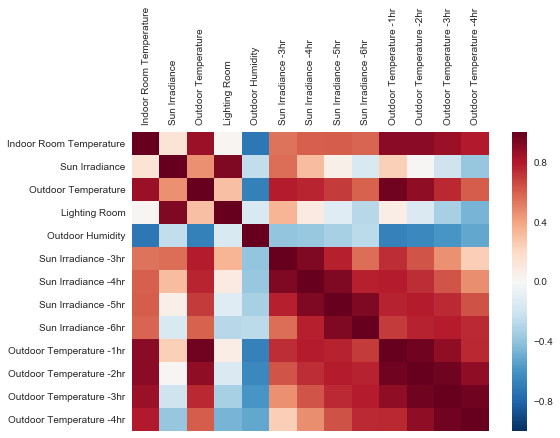

In [7]:
#Creating a plot using heatmap functionality to provide correlations between columns of dataset
fig = plt.figure("Figure for proving insight about Corelations")
plot = fig.add_axes()
plot = sns.heatmap(DF_lagged.corr(), annot=False)
plot.xaxis.tick_top() 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Plotting Indoor temperature,Sun Irradiation and Outdoor Temperature will give us greater understanding on how one depends on another.

To do so we introduce a function to normalize the data and eliminate the problem of different unit.

In the normalized graph below, 

1)We can see that the Indoor temperature is increasing w.r.t. outdoor temperature in real time but it takes time for sun irradiation to heat up the room walls/roof,so the Sun Irradiation will spike up before room indoor temperature. 

2)At some instances,Sun Irradiance is irregular.We can assume that sun Irradiance is irregular due to rainy/cloudy environment.

3)During night time, Sun Irradiation is zero.



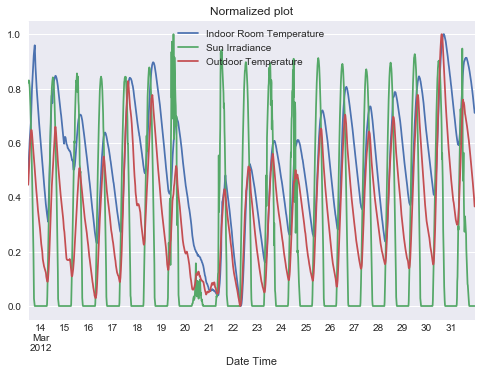

In [8]:
'''A function to normalize dataset's columns values to provide a ranged insight'''
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

#Plotting the normalized dataframe with selected columns
normalizedDF=normalize(DF_selected)
PlotDF=normalizedDF[["Indoor Room Temperature","Sun Irradiance","Outdoor Temperature"]]
PlotDF.plot()
plt.title("Normalized plot")
plt.show()

Let's add some time related features now like hour,Day of Week,Month, Day or night,Weekend or not etc.

We use a function to detect weekend and drop all the NaN values.

In [9]:
#Adding time-related features
DF_lagged['hour'] = DF_lagged.index.hour
DF_lagged['day_of_week'] = DF_lagged.index.dayofweek
DF_lagged['month'] = DF_lagged.index.month
DF_lagged['day_night'] = np.where((DF_lagged['hour']>=6)&(DF_lagged['hour']<=17), 1, 0)

'''A function to label a day of week as weekend or not'''
def weekend_detector(day):
    if (day==5 or day==6):
        weekend = 1
    else:
        weekend = 0
    return weekend   
DF_lagged['weekend'] = [weekend_detector(s) for s in DF_lagged['day_of_week']]
DF_lagged.dropna(inplace=True) #Dropping nan values

DF_lagged.head()

,Indoor Room Temperature,Sun Irradiance,Outdoor Temperature,Lighting Room,Outdoor Humidity,Sun Irradiance -3hr,Sun Irradiance -4hr,Sun Irradiance -5hr,Sun Irradiance -6hr,Outdoor Temperature -1hr,Outdoor Temperature -2hr,Outdoor Temperature -3hr,Outdoor Temperature -4hr,hour,day_of_week,month,day_night,weekend
Date Time,,,,,,,,,,,,,,,,,,
2012-03-13 17:45:00,24.1413,15.57000,19.7560,23.2427,47.0693,582.869,699.392,762.743,758.880,20.7107,21.7067,22.1080,21.2040,17,1,3,1,0
2012-03-13 18:00:00,24.2680,5.00933,19.5273,21.4213,49.5467,544.533,677.675,752.683,762.069,20.4627,21.4667,22.1373,21.5227,18,1,3,0,0
2012-03-13 18:15:00,24.3800,0.00000,19.3013,13.3620,52.2027,503.744,648.427,740.949,766.251,20.2047,21.1773,22.0800,21.7560,18,1,3,0,0
2012-03-13 18:30:00,24.0707,0.00000,19.0413,13.1027,53.8053,460.523,615.680,721.109,766.037,19.9760,20.9373,21.9373,21.9840,18,1,3,0,0
2012-03-13 18:45:00,23.5880,0.00000,18.7680,13.6067,54.9280,415.744,582.869,699.392,762.743,19.7560,20.7107,21.7067,22.1080,18,1,3,0,0


Now we have our dataframe with target and features(Time and Lagged):

In [10]:
target = DF_lagged[['Indoor Room Temperature']]
features = DF_lagged[[c for c in DF_lagged.columns if c not in ["Indoor Room Temperature"]]]

Creating a training dataset for machine learning and providing an independent testset which follows same probabilistic distribution of training!


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123524)

Implementing Linear regression technique of scikit-learn machine learning module to make

In [12]:
from sklearn import linear_model 
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,y_train)
prediction = linear_reg.predict(X_test)
predict_series = pd.Series(prediction.ravel(),index=y_test.index).rename('Indoor Room Temperature Prediction_LR')
LearnedDataset = pd.DataFrame(predict_series).join(y_test).dropna()

Plotting the learned dataset and verifying the predicted values with actual ones

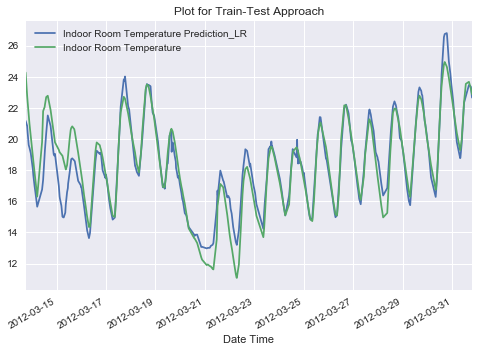

In [13]:
LearnedDataset.plot()
plt.title("Plot for Train-Test Approach")
plt.show()

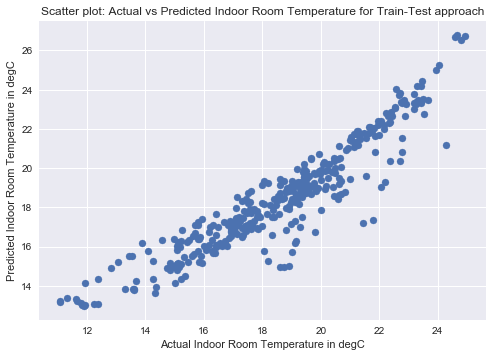

In [14]:
plt.figure()
plt.scatter(LearnedDataset['Indoor Room Temperature'],LearnedDataset['Indoor Room Temperature Prediction_LR'])
plt.xlabel("Actual Indoor Room Temperature in degC")
plt.ylabel("Predicted Indoor Room Temperature in degC")
plt.title("Scatter plot: Actual vs Predicted Indoor Room Temperature for Train-Test approach")
plt.show()

Calculating the accuracy metrics of implemented machine learning model


In [15]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
metric_R2_score = r2_score(y_test,prediction) #Perfectly accurate model gives metric_R2_score as 1 and co-efficient of variation as 0, this values varies from 0 to 1(inclusive)
metric_mean_absolute_error = mean_absolute_error(y_test,prediction)
metric_mean_squared_error = mean_squared_error(y_test,prediction)
coeff_variation = np.sqrt(metric_mean_squared_error)/float(y_test.mean())

print "The R2_score is "+str(metric_R2_score)
print "The mean absoulute error is "+str(metric_mean_absolute_error)
print "The mean squared error is "+str(metric_mean_squared_error)
print "Coefficient variation : "+str(coeff_variation)

The R2_score is 0.85960194484
The mean absoulute error is 0.754894065927
The mean squared error is 1.17948808638
Coefficient variation : 0.0585514891301


Implementing cross-validation approach to test the performance of the machine learning model

In [16]:
from sklearn.model_selection import cross_val_predict
predict_linearReg_CV = cross_val_predict(linear_reg,features,target,cv=10)
predict_DF_linearReg_CV=pd.DataFrame(predict_linearReg_CV, index = target.index,columns=["Indoor Room Temperature Prediction_CV"])
predict_DF_linearReg_CV = predict_DF_linearReg_CV.join(target)

Plotting the learned dataset and verifying the predicted values with actual ones

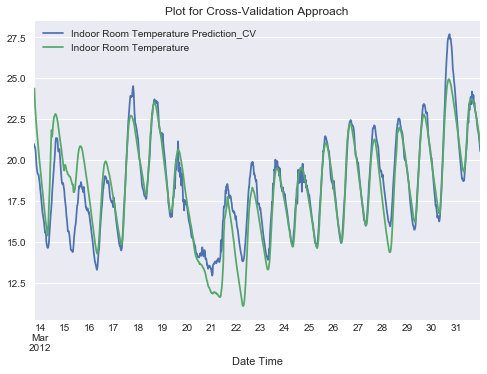

In [17]:
predict_DF_linearReg_CV.plot()
plt.title("Plot for Cross-Validation Approach")
plt.show()

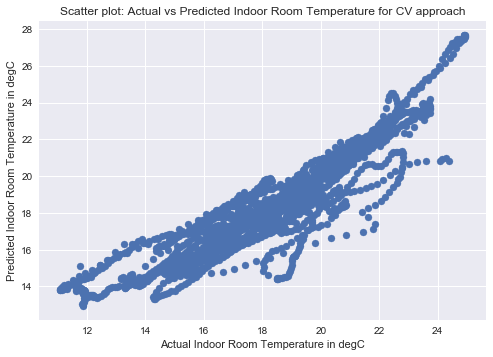

In [18]:
plt.figure()
plt.scatter(predict_DF_linearReg_CV['Indoor Room Temperature'],predict_DF_linearReg_CV['Indoor Room Temperature Prediction_CV'])
plt.xlabel("Actual Indoor Room Temperature in degC")
plt.ylabel("Predicted Indoor Room Temperature in degC")
plt.title("Scatter plot: Actual vs Predicted Indoor Room Temperature for CV approach")
plt.show()
